# Modeling Section #
## 1. Average track duration prediction

In this section, I'm going to try some different models for explaining and predicting track duration and popularity behavior over the years, also using other variables such as valence and energy to find a model that can be well fit to the dataset. 

### Collecting packages

In [1]:
# Collecting packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, round
import pandas as pd
import numpy as np

### Starting Spark Context and Spark Session

In [2]:
# Configure SparkUI
conf = SparkConf().set('spark.ui.port', '4050')

# Create a URL through you can access the Spark UI
get_ipython().system_raw('./ngrok http 4050 &')

# Access the URL
!curl -s http://localhost:4040/api/tunnels 

# Creating a context. Access SparkUI now in localhost:4050
sc = SparkContext(conf=conf)

In [3]:
# Starting Spark Session
spark = (
    SparkSession.builder                  
      .config('spark.ui.port', '4050')
      .appName("music_spark_session")
      .getOrCreate()
)

### Collecting clean data from data preparation section

In [120]:
path_data = "clean_data_music.csv"

schema_music = StructType([
    StructField('Index', IntegerType()),
    StructField('Track_duration', IntegerType()),
    StructField('Popularity', IntegerType()),
    StructField('Danceability', DoubleType()),
    StructField('Energy', DoubleType()),
    StructField('Key', IntegerType()),
    StructField('Loudness', DoubleType()),
    StructField('Acousticness', DoubleType()),
    StructField('Instrumentalness', DoubleType()),
    StructField('Liveness', DoubleType()),
    StructField('Valence', DoubleType()),
    StructField('Tempo', DoubleType()),
    StructField('Year', IntegerType())
])


In [121]:
df = spark.read.csv(
    path_data,
    header=True,
    sep=',',
    schema=schema_music
).drop('index')

In [122]:
df.show()

+--------------+----------+------------+------+---+--------+------------+----------------+--------+-------+-------+----+
|Track_duration|Popularity|Danceability|Energy|Key|Loudness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Year|
+--------------+----------+------------+------+---+--------+------------+----------------+--------+-------+-------+----+
|        216270|         0|       0.617| 0.872|  8| -12.305|      0.0158|           0.112|   0.408|  0.504|111.458|1992|
|        237120|        64|       0.825| 0.743|  2|  -5.995|      0.0142|         2.12E-5|   0.237|    0.8|127.045|2009|
|        312533|        56|       0.677| 0.665|  7|  -5.171|        0.56|         1.01E-6|   0.338|  0.706| 74.981|1999|
|        233400|        42|       0.683| 0.728|  9|   -8.92|       0.568|         5.08E-5|  0.0384|  0.833| 75.311|2014|
|        448720|         0|       0.319| 0.627|  0|  -9.611|       0.675|         7.29E-5|   0.289|  0.497| 85.818|1969|
|        193346|        79|     

### Fit track duration average by year with non linear model

In [123]:
df_track_dur = df.select('Year', 'Track_duration')\
                 .groupBy('Year').avg('Track_duration').orderBy('Year')\
                 .withColumnRenamed('avg(Track_duration)', 'Track_duration')\
                 .withColumn('Track_duration', round(col('Track_duration'), 2))


In [124]:
df_track_dur = df_track_dur.toPandas()

In [125]:
df_track_dur.head(10)

,Year,Track_duration
0,1956,119200.00
1,1958,139411.91
2,1959,227953.00
3,1960,162591.80
4,1961,160295.55
5,1962,152770.45
6,1963,153689.96
7,1964,155397.08
8,1965,176746.79
9,1966,162602.03


In [126]:
from sklearn.linear_model import LinearRegression

X = df_track_dur.drop('Track_duration', axis = 1).copy()
y = df_track_dur['Track_duration'].copy()

linear_reg = LinearRegression()
linear_reg.fit(X, y);

Ajusting with Polynomial, with 3rd degree curve

In [127]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)

X_poly = poly_features.fit_transform(X)

In [128]:
linear_reg.fit(X_poly, y)

y_fit_poly = linear_reg.predict(X_poly)

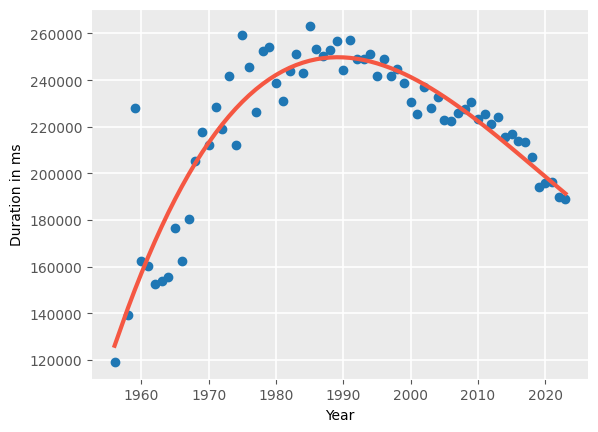

In [129]:
import matplotlib.pyplot as plt

ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.axisbelow':True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'grid.color': 'white',
    'grid.linewidth': '1.2',
    'xtick.color': '555555',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': '555555',
    'ytick.major.left': True,
    'ytick.minor.left': False,
}


plt.rcParams.update(ggplot_styles)

plt.scatter(X, y)
plt.plot(X, y_fit_poly, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Duration in ms');

Let's now predict average track duration for the next years to 2040 according to this shape, if this pattern continues

In [130]:
years_list = [i for i in range(2024, 2041)]
df_future = pd.DataFrame(years_list, columns =['Year'])
df_future.head(10)

,Year
0,2024
1,2025
2,2026
3,2027
4,2028
5,2029
6,2030
7,2031
8,2032
9,2033


In [131]:
X_poly_pred = poly_features.fit_transform(df_future)

In [132]:
y_pred_poly = linear_reg.predict(X_poly_pred)
y_pred_poly

array([188970.83468628, 186609.95075226, 184282.46695805, 181993.89537525,
       179749.74806404, 177555.53709412, 175416.77453613, 173338.97245598,
       171327.64292526, 169388.2980051 , 167526.44976711, 165747.61027718,
       164057.29160595, 162461.00581932, 160964.26498508, 159572.58117199,
       158291.46644688])

In [133]:
y_full_poly = np.append(y_fit_poly, y_pred_poly)

In [134]:
# Adding randomness for visualization and simulation purposes
from numpy.random import seed
from numpy.random import randint

seed(1)

y_simulation_points = y_pred_poly + randint(-7000, 7000, len(y_pred_poly))

In [135]:
y_pred_points = pd.DataFrame(y_simulation_points)

In [136]:
y_pred_poly = pd.DataFrame(y_pred_poly)

In [137]:
X_pred_plot = pd.concat([X, df_future])
y_pred_points = pd.concat([y, y_pred_points])

In [138]:
X_pred_plot = X_pred_plot.reset_index().drop(columns = ['index'])
y_pred_points = y_pred_points.reset_index().drop(columns = ['index'])

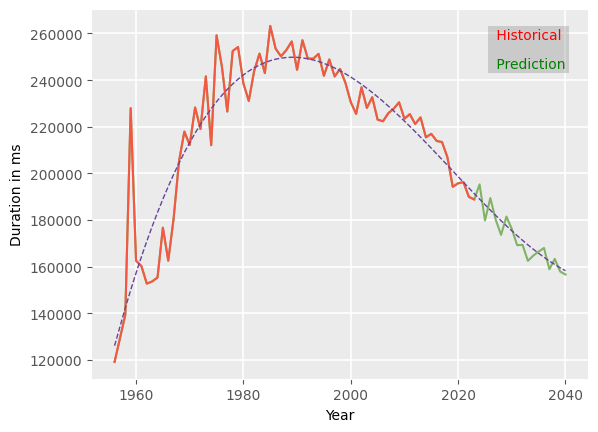

In [139]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1,1)

t1 = axs.text(0.88,0.92, ' Historical ', ha='center', color='red', transform=axs.transAxes)
t2 = axs.text(0.88,0.84, ' Prediction', ha='center', color='green', transform=axs.transAxes)

fig.canvas.draw()

textobjs = [t1,t2]

xmin = min([t.get_window_extent().xmin - 4 for t in textobjs])
xmax = max([t.get_window_extent().xmax + 4 for t in textobjs])
ymin = min([t.get_window_extent().ymin - 2 for t in textobjs])
ymax = max([t.get_window_extent().ymax + 2 for t in textobjs])

xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, facecolor='grey', alpha=0.3, transform=fig.transFigure)

axs.add_patch(rect)

plt.plot(X_pred_plot, y_pred_points, color = '#7FB366')
plt.plot(X, y, color = '#f55742')
plt.plot(X_pred_plot, y_full_poly, color = '#664499', linewidth=1, linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Duration in ms');

### Linear correlation analysis since the 90's

In [140]:
df_linear = df_track_dur[df_track_dur["Year"]>= 1990].reset_index()
df_linear.drop(columns = 'index', inplace= True)
df_linear.head()


,Year,Track_duration
0,1990,244406.04
1,1991,257118.97
2,1992,249239.06
3,1993,249195.12
4,1994,251273.13


Since the 90's, the average song duration has been decreasing linearly each year, with a very high indicator for linearity, as duration and time present near -1 correlation.

In [141]:
df_linear.corr()['Track_duration']['Year']

-0.9491955319714159

In [142]:
lr = LinearRegression()

X = df_linear.drop('Track_duration', axis = 1).copy()
y = df_linear['Track_duration'].copy()

lr.fit(X, y);

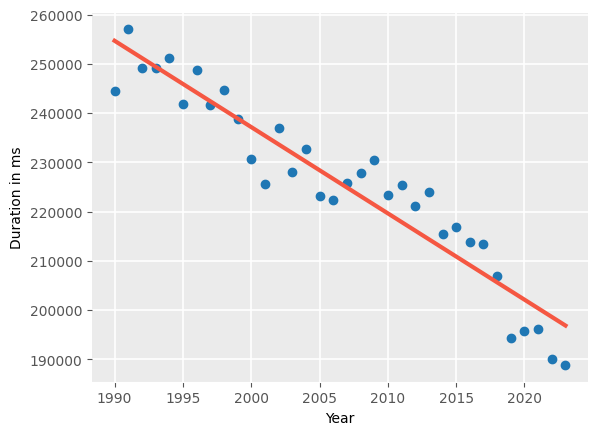

In [143]:
lr_line = lr.predict(X)

plt.scatter(X, y)
plt.plot(X, lr_line, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Duration in ms');

In [144]:
lr.coef_

array([-1753.3727945])

This shows since the 90's the duration of songs has been decreasing almost 2 seconds by year.

In [145]:
linear_prediction = lr.predict(df_future)
linear_prediction = linear_prediction/1000
linear_prediction

array([195.0988961 , 193.3455233 , 191.59215051, 189.83877771,
       188.08540492, 186.33203212, 184.57865933, 182.82528653,
       181.07191374, 179.31854095, 177.56516815, 175.81179536,
       174.05842256, 172.30504977, 170.55167697, 168.79830418,
       167.04493138])

In [146]:
linear_prediction = np.round(linear_prediction, 2)

In [147]:
linear_pred = df_future

In [148]:
linear_prediction = pd.DataFrame(linear_prediction, columns =['Duration_sec'])

In [149]:
linear_pred['Duration_sec'] = linear_prediction

In [150]:
linear_pred['Average_duration'] = linear_pred['Duration_sec']\
                               .astype('datetime64[s]')\
                               .dt.strftime("%M:%S")

linear_pred.drop(columns = ['Duration_sec'],inplace=True)

In [151]:
linear_pred.head(20)

,Year,Average_duration
0,2024,03:15
1,2025,03:13
2,2026,03:11
3,2027,03:09
4,2028,03:08
5,2029,03:06
6,2030,03:04
7,2031,03:02
8,2032,03:01
9,2033,02:59


### Linear correlation analysis since 2010

Using linear correlation since 2010

In [152]:
df_linear = df_track_dur[df_track_dur["Year"]>= 2009].reset_index()
df_linear.drop(columns = 'index', inplace= True)

In [153]:
df_linear.corr()['Track_duration']['Year']

-0.9664539012842049

That indicates an even stronger correlation and a more defined linear decay since 2010.

In [154]:
lr = LinearRegression()

X = df_linear.drop('Track_duration', axis = 1).copy()
y = df_linear['Track_duration'].copy()

lr.fit(X, y);

In [155]:
lr.coef_

array([-3034.56496429])

In this case, since 2010, songs have been lasting 3 seconds less each year.

In [156]:
df_track_dur['Track_duration'] = df_track_dur['Track_duration']/1000
df_track_dur.rename(columns={"Track_duration": "Average_duration"}, inplace=True)

df_track_dur

,Year,Average_duration
0,1956,119.20000
1,1958,139.41191
2,1959,227.95300
3,1960,162.59180
4,1961,160.29555
...,...,...
62,2019,194.27445
63,2020,195.78324
64,2021,196.25128
65,2022,189.96767


In [157]:
df_future.drop(columns = ['Average_duration'], inplace = True)

In [158]:
linear_prediction = lr.predict(df_future)
linear_prediction = linear_prediction/1000
linear_prediction

array([186.16014895, 183.12558399, 180.09101902, 177.05645406,
       174.0218891 , 170.98732413, 167.95275917, 164.9181942 ,
       161.88362924, 158.84906427, 155.81449931, 152.77993435,
       149.74536938, 146.71080442, 143.67623945, 140.64167449,
       137.60710952])

In [159]:
linear_prediction = np.round(linear_prediction, 2)
linear_pred = df_future
linear_prediction = pd.DataFrame(linear_prediction, columns =['Average_duration'])
linear_pred['Average_duration'] = linear_prediction['Average_duration'].apply(lambda i: i + list(randint(-7, 7, 1))[0])

seed(1)

linear_pred

,Year,Average_duration
0,2024,184.16
1,2025,178.13
2,2026,177.09
3,2027,181.06
4,2028,179.02
5,2029,173.99
6,2030,172.95
7,2031,170.92
8,2032,156.88
9,2033,155.85


In [160]:
linear_pred.rename(columns={"Average_duration": "Average_duration_pred"}, inplace=True)

In [161]:
df_plot = df_track_dur.merge(linear_pred, how = 'outer', on = ['Year'])

In [162]:
df_plot['Average_duration'] = df_plot['Average_duration']

C:\Users\Matheus\AppData\Local\Temp\ipykernel_4396\308146019.py:26: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend((historical, prediction),


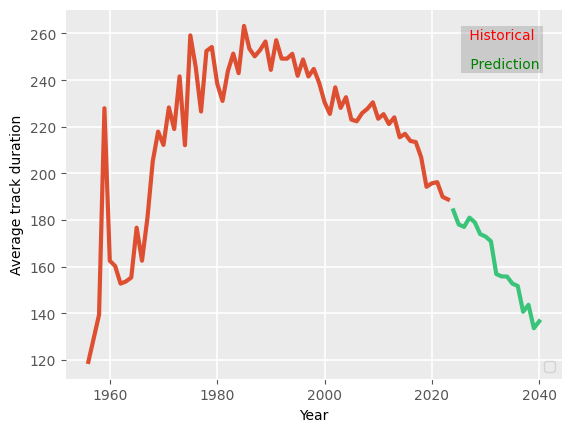

In [167]:
fig, axs = plt.subplots(1,1)

t1 = axs.text(0.88,0.92, ' Historical ', ha='center', color='red', transform=axs.transAxes)
t2 = axs.text(0.88,0.84, ' Prediction', ha='center', color='green', transform=axs.transAxes)

fig.canvas.draw()

textobjs = [t1,t2]

xmin = min([t.get_window_extent().xmin - 4 for t in textobjs])
xmax = max([t.get_window_extent().xmax + 4 for t in textobjs])
ymin = min([t.get_window_extent().ymin - 2 for t in textobjs])
ymax = max([t.get_window_extent().ymax + 2 for t in textobjs])

xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, facecolor='grey', alpha=0.3, transform=fig.transFigure)

axs.add_patch(rect)

historical = plt.plot(df_plot['Year'], df_plot['Average_duration'], color = '#de4e31', linewidth = 3)
prediction = plt.plot(df_plot['Year'], df_plot['Average_duration_pred'], color = '#39c47a', linewidth = 3)
plt.xlabel('Year')
plt.ylabel('Average track duration')
plt.legend((historical, prediction),
           ('Historical', 'Prediction'),
           loc='lower right',
           ncol=1,
           fontsize=10)
plt.show()

So, if song duration continues to decrease in the same rate since 2010, till 2040 songs will last at average near 2 minutes.

In [165]:
spark.stop()